In [1]:
from meshparty import meshwork
import warnings
from common_setup import project_info, project_paths
from caveclient import CAVEclient
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bitsandbobs as bab
import tqdm
import pickle 

from src.loading_core_data import *
from src.synapse_budget import *
from src.card_plotting_code import *
from src.neuron_info import *

voxel_resolution = np.array([4, 4, 40])
data_dir = project_paths.data
process_dir = 'synapse_files'

synapse_table = project_info.synapse_table
ct_column_table = project_info.column_table
soma_table = project_info.soma_table
proofreading_table = project_info.soma_table



In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
import card_config
visConfig = card_config.VisualizationConfig()

In [4]:
client = CAVEclient(project_info.datastack)
print(f'Making cards for {client.materialize.version}')

Making cards for 62


In [5]:
axon_color = [0.214, 0.495, 0.721]
dendrite_color = [0.894, 0.103, 0.108]

def morpho_plot(nrn,
                layer_bnds,
                height_bounds,
                width_bounds, 
                axon_color=axon_color,
                dendrite_color=dendrite_color,
                linewidth=0.5,
                soma_size=25,
                colorize=True,
                bar_start = None,
                bar_length=100,
                text_voffset=10,
                ax=None):
    
    if colorize == False:
        axon_color = 'k'
        dendrite_color = 'k'

    axon_pts = nrn.skeleton.vertices[nrn.anno.is_axon.mesh_index.to_skel_mask]
    dend_pts = nrn.skeleton.vertices[~nrn.anno.is_axon.mesh_index.to_skel_mask]
    soma_pt = nrn.skeleton.vertices[nrn.skeleton.root]

    if ax is None:
        ax = plt.gca()
    ax.scatter(axon_pts[:, 0]/1000, axon_pts[:, 1] /
               1000, marker='.', s=linewidth, color=axon_color)
    ax.scatter(dend_pts[:, 0]/1000, dend_pts[:, 1]/1000,
               marker='.', s=linewidth, color=dendrite_color)
    ax.scatter(soma_pt[0]/1000, soma_pt[1]/1000, s=soma_size,
               color='w', edgecolor='k', linewidth=0.5, alpha=1)
    plot_layers(layer_bnds, height_bounds, width_bounds, color=(
        0.5, 0.5, 0.5), linewidth=0.5, linestyle=':', ax=ax)
    
    if bar_start is None:
        bar_start = (layer_bnds[-1]+50, width_bounds[0])
    if bar_length > 0:
        ax.hlines(bar_start[0], bar_start[1],
                  bar_start[1]+bar_length, linewidth=5, color='k')
        ax.text(bar_start[1]+bar_length/2, bar_start[0]+text_voffset,
                f'{bar_length} $\mu$m', color='k', ha='center', va='top', fontsize=8)
        
    ax.set_aspect('equal')
    sns.despine(ax=ax, offset=5, bottom=True)
    ax.set_xticks([])
    return ax

In [6]:
configuration_name = 'column'

def baseline_data_filename(process_dir, configuration_name, version):
    return f"{process_dir}/{configuration_name}_v{version}_files.pkl"

bd_filename = baseline_data_filename(process_dir, configuration_name, client.materialize.version)

def extract_baseline_data(bd_filename):
    with open(bd_filename, "rb") as f:
        baseline_data = pickle.load(f)

    cell_type_df = baseline_data.get('cell_type_df')
    layer_bins = baseline_data.get('layer_bins')
    syn_profile_bin_comp_df = baseline_data.get('syn_profile_bin_comp_df')
    syn_profile_count_comp_long = baseline_data.get('syn_profile_count_comp_long')
    syn_profile_comp_count = baseline_data.get('syn_profile_comp_count')
    layerConfig = baseline_data.get('layerConfig')
    catConfig = baseline_data.get('catConfig')
    return cell_type_df, layer_bins, syn_profile_bin_comp_df, syn_profile_count_comp_long, syn_profile_comp_count, layerConfig, catConfig

def define_comp(row):
    if row['is_soma']:
        return 'soma'
    elif row['is_apical']:
        return 'apical'
    elif row['is_dendrite']:
        return 'basal'
    else:
        return 'other'

In [7]:
cell_type_df, layer_bins, syn_profile_bin_comp_df, syn_profile_count_comp_long, syn_profile_comp_count, layerConfig, catConfig = \
    extract_baseline_data(bd_filename)


In [8]:
i_groups = [{'cts': ['BC'],
  'labels': ['']},
 {'cts': ['BPC'],
  'labels': ['']},
 {'cts': ['MC'],
  'labels': ['']},
 {'cts': ['NGC'],
  'labels': ['']},
 {'cts': ['Unsure'],
  'labels': ['']}]

catConfig.i_groups = i_groups

In [11]:
cell_type_df = cell_type_df.rename(columns={'soma_depth': 'soma_depth_um'})

In [12]:
soma_target_df = cell_type_df[['pt_root_id', 'soma_depth_um']].rename(columns={'pt_root_id':'post_pt_root_id'})

In [13]:
soma_df, soma_count_df = get_soma_data(soma_table, client)

In [14]:
cell_type_df['valence'] = np.where(cell_type_df['classification_system']=='aibs_coarse_inhibitory', 'Inh', 'Exc')

In [15]:
cell_type_df.query('cell_type == "MC"').sort_values(by='soma_depth_um')

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,soma_depth_um,layer,valence
1771,992,True,aibs_coarse_inhibitory,MC,90921572109929556,864691135210074560,"[190416, 99456, 20385]",397.824,L1,Inh
1764,980,True,aibs_coarse_inhibitory,MC,89021959681198257,864691135433422578,"[176480, 101824, 20540]",407.296,L2/3,Inh
1808,2415,True,aibs_coarse_inhibitory,MC,91063752908438555,864691135065094212,"[191120, 109792, 21792]",439.168,L2/3,Inh
1088,370,True,aibs_coarse_inhibitory,MC,90289765240834294,864691135428614704,"[185856, 110288, 20415]",441.152,L2/3,Inh
1264,2604,True,aibs_coarse_inhibitory,MC,88249415457993138,864691134940086115,"[170736, 113344, 21601]",453.376,L2/3,Inh
1393,684,True,aibs_coarse_inhibitory,MC,90853814907198518,864691135497601299,"[189696, 118960, 21975]",475.840,L2/3,Inh
240,25,True,aibs_coarse_inhibitory,MC,88532745726627869,864691135354870991,"[172624, 126960, 20812]",507.840,L2/3,Inh
1781,987,True,aibs_coarse_inhibitory,MC,90293820025094730,864691135815624783,"[185760, 140784, 22627]",563.136,L2/3,Inh
805,1194,True,aibs_coarse_inhibitory,MC,88676713231585599,864691135697462549,"[173744, 151152, 22254]",604.608,L4,Inh
583,232,True,aibs_coarse_inhibitory,MC,88817588091910167,864691135293118220,"[174720, 152224, 21821]",608.896,L4,Inh


In [32]:
def process_presyn_df(nrn,
                      syn_profile_bin_comp_df,
                      soma_target_df,
                      catConfig):
    
    pre_syn_df = nrn.anno.pre_syn.df
    
    # Add cell type and component information
    pre_syn_df = pre_syn_df.merge(syn_profile_bin_comp_df[['id', 'dist_to_root', 'syn_depth', 'is_apical', 'is_soma', 'is_dendrite', 'cell_type', 'cell_type_comp', 'layer', 'valence']],
                                  how='inner',
                                  on='id')
    pre_syn_df['cell_type'] = pd.Categorical(
        pre_syn_df['cell_type'], categories=catConfig.order, ordered=True)
    # Add target soma depth
    pre_syn_df = pre_syn_df.merge(soma_target_df, how='left', on='post_pt_root_id')
    pre_syn_df['comp'] = pre_syn_df.apply(define_comp, axis=1)
    pre_syn_df['comp'] = pd.Categorical(pre_syn_df['comp'], categories=['soma', 'basal', 'apical', 'other'][::-1], ordered=True)

    try:
        pre_syn_df = pre_syn_df.rename(columns={'syn_depth': 'syn_depth_um'})
    except:
        pass
    return pre_syn_df

In [42]:
def get_soma_id(oid, soma_df):
    try:
        return soma_df.query('pt_root_id == @oid')['id'].values[0]
    except:
        return None

def get_celltype(oid, cell_type_df):
    nrn_row = cell_type_df.query('pt_root_id == @oid')
    if len(nrn_row) == 1:
        return nrn_row['cell_type'].iloc[0]
    else:
        return None

In [104]:
oid = 864691135293118220

nrn = meshwork.load_meshwork(f'{project_paths.skeletons}/skeleton_files/{oid}.h5')


In [37]:
oid = 864691135293118220

nrn = meshwork.load_meshwork(f'{project_paths.skeletons}/skeleton_files/{oid}.h5')

pre_syn_df = process_presyn_df(nrn, syn_profile_bin_comp_df, soma_target_df, catConfig)
soma_position = nrn.skeleton.vertices[nrn.skeleton.root]
soma_depth = soma_position[1]/1000

nrn_soma_id = get_soma_id(oid, soma_df)
nrn_subtype = get_celltype(oid, cell_type_df)
    
syn_df_bin_count_long = full_synapse_data(
        pre_syn_df,
        'cell_type_comp',
        layer_bins,
        syn_profile_count_comp_long,
        order=catConfig.order_comp)

res_df = stratified_tables(
    syn_df_bin_count_long, 'cell_type_comp', order=catConfig.order_comp)

In [43]:
def preprocess_neuron(oid,
                      cell_type_df,
                      soma_df,
                      layer_bins,
                      syn_profile_bin_comp_df,
                      syn_profile_count_comp_long,
                      soma_target_df,
                      catConfig,
                      skeleton_folder,
                      has_soma=True):
    
    nrn = meshwork.load_meshwork(f'{skeleton_folder}/{oid}.h5')

    pre_syn_df = process_presyn_df(nrn, syn_profile_bin_comp_df, soma_target_df, catConfig)

    soma_position = nrn.skeleton.vertices[nrn.skeleton.root]
    soma_depth = soma_position[1]/1000

    nrn_soma_id = get_soma_id(oid, soma_df)
    nrn_subtype = get_celltype(oid, cell_type_df)

    syn_df_bin_count_long = full_synapse_data(
            pre_syn_df,
            'cell_type_comp',
            layer_bins,
            syn_profile_count_comp_long,
            order=catConfig.order_comp)

    res_df = stratified_tables(
        syn_df_bin_count_long, 'cell_type_comp', order=catConfig.order_comp)
    
    return nrn, pre_syn_df, soma_depth, nrn_soma_id, nrn_subtype, syn_df_bin_count_long, res_df

In [19]:
def target_dist_from_soma(df, color, bins=np.arange(-1,750,20), offset=5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,2), facecolor='w')
    ax2 = ax.twinx()

    ax2.set_yticks([], minor=False)
    ax2.set_yticks(np.arange(0,1.01, 0.25), minor=True)
    ax2.grid(True, axis='y', linestyle=':', which='both')

    sns.histplot(x='dist_to_root',
                 cumulative=True,
                 stat='density',
                 element='step',
                 fill=True,
                 alpha=0.1,
                 data=df,
                 color=(0.4, 0.4, 0.4),
                 ax=ax2,
                 bins=np.arange(-1,750,1))

    sns.histplot(x='dist_to_root',
                 stat='count',
                 element='step',
                 fill=False,
                 data=df,
                 color=color,
                 line_kws={'linewidth':4},
                 ax=ax,
                 alpha=1,
                 bins=bins)

    ax2.plot(np.median(df["dist_to_root"])*np.ones(2), [0, 1], color='k', linestyle=':', linewidth=1)
    ax2.set_ylim(0,1.05)
    ax2.set_ylabel('')
    ax2.xaxis.set_visible(False)

    ax.set_ylabel('# Syn', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    sns.despine(ax=ax2, left=True, right=True, top=True, offset=offset)
    sns.despine(ax=ax, right=True, bottom=False, offset=offset)
    ax.set_xticks(np.arange(0,max(bins[~np.isinf(bins)]), 50), minor=True)
    _ = ax.set_xlabel('Dist. to soma ($\mu m$)')
    ax.set_xlim(-1,max(bins[~np.isinf(bins)]))
    return ax, ax2

In [20]:
def compartment_target_distance_plot(df,
                                     palettes,
                                     layer_bounds,
                                     height_bounds,
                                     size=10,
                                     alpha=0.5,
                                     markers=('o', 'd', 'X'),
                                     ax=None,
                                     max_dist=None,
                                     ):
    if ax is None:
        ax = plt.gca()
    if max_dist is None:
        max_dist = np.max(df['dist_to_root'])
        
    palette, palette_apical, palette_soma = palettes
    marker, marker_apical, marker_soma = markers
    ax = sns.scatterplot(y='soma_depth_um',
                     x ='dist_to_root',
                     hue='classification_system',
                     edgecolor=None,
                     palette=palette,
                     data=df.query('not is_apical and not is_soma'),
                     marker=marker,
                     s=size,
                     alpha=alpha,
                     ax=ax) 
    
    ax = sns.scatterplot(x='dist_to_root',
                     y='soma_depth_um',
                     hue='classification_system',
                     edgecolor=None,
                     palette=palette_apical,
                     data=df.query('is_apical'),
                     marker=marker_apical,
                     s=size,
                     alpha=alpha,
                     ax=ax)
    
    ax = sns.scatterplot(x='dist_to_root',
                     y='soma_depth_um',
                     hue='classification_system',
                     edgecolor=None,
                     palette=palette_soma,
                     data=df.query('is_soma'),
                     marker=marker_soma,
                     s=size,
                     alpha=alpha,
                     ax=ax)
    
    
    ax.plot([0, max_dist], [soma_depth, soma_depth],
            linestyle='--', marker=None, color='k', linewidth=2, alpha=0.5)

    layer_x, layer_y = generate_layer_data(layer_bounds, (-5, max_dist+5) , axis='x')
    layer_ticks = generate_layer_ticks(layer_bounds, height_bounds)
    layer_tick_labels = ['L1', 'L2/3', 'L4', 'L5', 'L6', 'WM']

    ax.plot(layer_x, layer_y, color=(0.6, 0.6, 0.6), linewidth=1,
            linestyle='-', alpha=0.3, zorder=-10)

    ax.set_xlabel('Target distance to root')

    ax.set_yticks(layer_ticks)
    ax.set_yticklabels(layer_tick_labels)
    ax.set_ylabel('Target Soma Depth')

    ax.set_xlim(-5, max_dist+5)
    ax.set_ylim(*visConfig.height_bounds)

    ax.invert_yaxis()
    ax.legend().remove()
#     ax.set_aspect('equal')
    ax.xaxis.set_label_position('top')
    sns.despine(ax=ax, offset=5, top=False, bottom=True)
    return ax

In [21]:
def synapse_location_plot(df,
                          palette,
                          layer_bounds,
                          height_bounds,
                          size=10,
                          alpha=0.5,
                          marker='o',
                          ax=None
                          ):
    if ax is None:
        ax = plt.gca()
    ax = sns.scatterplot(y='syn_depth_um',
                     x='soma_depth_um',
                     hue='classification_system',
                     edgecolor='k',
                     palette=palette,
                     data=df,
                     marker=marker,
                     s=size,
                     alpha=alpha,
                     ax=ax)
    
    ax.plot(height_bounds, height_bounds, color='k',
                linestyle=':', linewidth=0.5)

    ax.plot([soma_depth], [soma_depth], 'wo', markersize=5,
            markeredgecolor='k', linewidth=0.5, alpha=1)

    layer_x, layer_y = generate_layer_data(layer_bounds, height_bounds, axis='x')
    layer_ticks = generate_layer_ticks(layer_bounds, height_bounds)
    layer_tick_labels = ['L1', 'L2/3', 'L4', 'L5', 'L6', 'WM']

    ax.plot(layer_x, layer_y, color='k', linewidth=0.5,
            linestyle='-', alpha=0.5, zorder=0)
    ax.plot(layer_y, layer_x, color='k', linewidth=0.5,
            linestyle='-', alpha=0.5, zorder=0)

    ax.set_xticks(layer_ticks)
    ax.set_xticklabels(layer_tick_labels)
    ax.set_xlabel('Target Soma Depth')

    ax.set_yticks(layer_ticks)
    ax.set_yticklabels(layer_tick_labels)
    ax.set_ylabel('Synapse Depth')

    ax.set_xlim(*height_bounds)
    ax.set_ylim(*height_bounds)

    ax.invert_yaxis()
    ax.legend().remove()
    ax.set_aspect('equal')
    ax.xaxis.set_label_position('top')
    sns.despine(ax=ax, offset=5, top=False, bottom=True)
    return ax

In [22]:
def target_summary_plot(df,
                        res_df,
                        fig,
                        gridspec,
                        groups,
                        num_rows,
                        palette,
                        cell_type='cell_type',
                        component='comp',
                        cell_type_component='cell_type_comp',
                        first_category=None,
                        width_ratio=4,
                        preference_width=1.0,
                        wspace=0.3,
                        min_xmax=10):
    g = gridspec.subgridspec(nrows=num_rows, ncols=3, wspace=wspace, width_ratios=(1, width_ratio, width_ratio*preference_width))
    ax_bar = fig.add_subplot(g[:,1])

    output_count_bar(df,
                     num_rows=num_rows,
                     labels=None,
                     cell_type=cell_type,
                     hue=component,
                     min_xmax=min_xmax,
                     palette=palette,
                     first_category=first_category,
                     ax=ax_bar)

    axes_spec = []
    for col in range(num_rows):
        axes_spec.append(fig.add_subplot(g[col, 2]))
    output_preference_index(res_df,
                            groups,
                            axes=axes_spec,
                            extra_mult=2,
                            cell_type_column=cell_type_component,
                            palette=visConfig.spec_palette)

### actual cardmaking

In [79]:
visConfig.axon_color = [0.214, 0.495, 0.721]
visConfig.dendrite_color = [0.894, 0.103, 0.108]
visConfig.other_color = [0.8, 0.8, 0.8]

visConfig.presyn_color = visConfig.axon_color
visConfig.postsyn_color = visConfig.dendrite_color

visConfig.e_palette_name = 'RdPu'
visConfig.i_palette_name = 'Greens'
visConfig.e_colors = sns.color_palette(visConfig.e_palette_name, n_colors=9)
visConfig.i_colors = sns.color_palette(visConfig.i_palette_name, n_colors=9)

visConfig.base_ind = 6
visConfig.soma_ind = 8
visConfig.apical_ind = 4

visConfig.e_color = visConfig.e_colors[visConfig.base_ind]
visConfig.i_color = visConfig.i_colors[visConfig.base_ind]

visConfig.valence_palette = {'aibs_coarse_excitatory': visConfig.e_color,
                             'aibs_coarse_inhibitory': visConfig.i_color}

visConfig.e_basal_color = visConfig.e_color
visConfig.e_soma_color = visConfig.e_colors[visConfig.soma_ind]
visConfig.e_apical_color = visConfig.e_colors[visConfig.apical_ind]

visConfig.i_basal_color = visConfig.i_color
visConfig.i_soma_color = visConfig.i_colors[visConfig.soma_ind]
visConfig.i_apical_color= visConfig.i_colors[visConfig.apical_ind]

visConfig.e_component_palette = {'basal': visConfig.e_basal_color,
                                 'soma': visConfig.e_soma_color,
                                 'apical': visConfig.e_apical_color, 
                                 'other': visConfig.other_color}

visConfig.i_component_palette = {'basal': visConfig.i_basal_color,
                                 'soma': visConfig.i_soma_color,
                                 'apical': visConfig.i_apical_color, 
                                 'other': visConfig.other_color}

visConfig.apical_palette = {'aibs_coarse_excitatory': visConfig.e_apical_color,
                            'aibs_coarse_inhibitory': visConfig.i_apical_color,
                           }

visConfig.soma_palette = {'aibs_coarse_excitatory': visConfig.e_soma_color,
                          'aibs_coarse_inhibitory': visConfig.i_soma_color,
                          }

visConfig.depth_bandwidth = 0.1
visConfig.markers = ('o', 'd', 'X')
visConfig.min_dist_bin_max = 200
visConfig.dist_bin_spacing = 20

In [24]:
def create_binning(df, min_max, bin_spacing, column='dist_to_root'):
    actual_max = df[column].max()
    bins = np.arange(-1, np.max((actual_max, min_max)), bin_spacing)
    return np.append(bins, np.inf)

In [61]:
oid = 864691135058546331
nrn = 

In [68]:
inhib_oids = cell_type_df.query('classification_system == "aibs_coarse_inhibitory"').sort_values(by=['cell_type', 'soma_depth_um'])['pt_root_id'].values

In [71]:
card_dir = f'{project_paths.plots}/cards_v2'
os.makedirs(card_dir)

In [78]:
from loguru import logger 

logger.add('card_log.log')

for oid in tqdm.tqdm(inhib_oids):
    try:
        nrn, pre_syn_df, soma_depth, nrn_soma_id, nrn_subtype, syn_df_bin_count_long, res_df = preprocess_neuron(oid,
                                                                                                                 cell_type_df,
                                                                                                                 soma_df,
                                                                                                                 layer_bins,
                                                                                                                 syn_profile_bin_comp_df, 
                                                                                                                 syn_profile_count_comp_long, 
                                                                                                                 soma_target_df, 
                                                                                                                 catConfig,
                                                                                                                 f'{project_paths.skeletons}/skeleton_files',
                                                                                                                 )
        title = f'{nrn_subtype}$\sim${nrn_soma_id}$\sim${oid}'
        fig = card_figure_v2(nrn, pre_syn_df, soma_depth, syn_df_bin_count_long, res_df, visConfig, layerConfig, catConfig, title=title)
        fig.savefig(f'{card_dir}/{nrn_subtype}_id{nrn_soma_id}_{oid}.pdf', bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        logger.debug(e)

In [55]:
def card_figure_v2(nrn, pre_syn_df, soma_depth, syn_df_bin_count_long, res_df, visConfig, layerConfig, catConfig, title=None):
    fig = plt.figure(figsize=(33,5), dpi=72, facecolor='w')
    
    bins = create_binning(pre_syn_df, visConfig.min_dist_bin_max, visConfig.dist_bin_spacing)
    gmain = fig.add_gridspec(1,6, wspace=0.05, width_ratios=(6, 1, 5, 4, 4, 4))

    ax_morpho = fig.add_subplot(gmain[0,0])
    morpho_plot(nrn,
               layerConfig.layer_bounds,
               visConfig.height_bounds,
               visConfig.width_bounds,
               linewidth=1,
               bar_length=200,
               axon_color=visConfig.axon_color,
               dendrite_color=visConfig.dendrite_color,
               ax=ax_morpho)
    ax_morpho.set_title(title)

    ax_syn_dens = fig.add_subplot(gmain[0,1])
    synapse_depth_distribution_plot(
        oid,
        pd.concat([nrn.anno.pre_syn.df, nrn.anno.post_syn.df]),
        visConfig.height_bounds,
        layerConfig.layer_bounds,
        soma_depth=soma_depth,
        bw=visConfig.depth_bandwidth,
        post_color=visConfig.postsyn_color,
        pre_color=visConfig.presyn_color,
        ax=ax_syn_dens)
    ax_syn_dens.set_ylabel(None)

    ax_syns = fig.add_subplot(gmain[0,2])
    synapse_location_plot(pre_syn_df,
                          visConfig.valence_palette,
                          layerConfig.layer_bounds,
                          layerConfig.height_bounds,
                          size=10,
                          alpha=0.6,
                          marker=visConfig.markers[0],
                          ax=ax_syns,
                          )

    g1 = gmain[0,3]
    g = g1.subgridspec(2,2, wspace=0.4, width_ratios=(1,1), height_ratios=(4,1))
    ax_e_tall = fig.add_subplot(g[0,0])
    compartment_target_distance_plot(pre_syn_df.query('classification_system == "aibs_coarse_excitatory"'),
                                      (visConfig.valence_palette, visConfig.apical_palette, visConfig.soma_palette),
                                      layerConfig.layer_bounds,
                                      visConfig.height_bounds,
                                      size=15,
                                      alpha=0.5,
                                      markers=visConfig.markers,
                                      ax=ax_e_tall,
                                      max_dist=np.max(bins[~np.isinf(bins)]),
                                      )

    ax_e_hist = fig.add_subplot(g[1,0], sharex=ax_e_tall)
    target_dist_from_soma(pre_syn_df.query('classification_system=="aibs_coarse_excitatory"'), color=visConfig.e_color, ax=ax_e_hist, bins=bins)

    ax_i_tall = fig.add_subplot(g[0,1], sharey=ax_e_tall)
    compartment_target_distance_plot(pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
                                      (visConfig.valence_palette, visConfig.apical_palette, visConfig.soma_palette),
                                      layerConfig.layer_bounds,
                                      visConfig.height_bounds,
                                      size=15,
                                      alpha=0.5,
                                      markers=visConfig.markers,
                                      ax=ax_i_tall,
                                      max_dist=np.max(bins[~np.isinf(bins)]),
                                      )

    ax_i_hist = fig.add_subplot(g[1,1], sharex=ax_i_tall)
    target_dist_from_soma(pre_syn_df.query('classification_system=="aibs_coarse_inhibitory"'), color=visConfig.i_color, ax=ax_i_hist, bins=bins)

    g_excbar = gmain[0,4]
    num_rows = max([len(catConfig.e_groups), len(catConfig.i_groups)])
    target_summary_plot(pre_syn_df.query('classification_system == "aibs_coarse_excitatory"'),
                        res_df,
                        fig,
                        g_excbar,
                        catConfig.e_groups,
                        num_rows,
                        visConfig.e_component_palette,
                        width_ratio=3,
                        preference_width=0.75)

    g_inhbar = gmain[0,5]
    target_summary_plot(pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
                        res_df,
                        fig,
                        g_inhbar,
                        catConfig.i_groups,
                        num_rows,
                        visConfig.i_component_palette,
                        first_category='BC',
                        width_ratio=3,
                        preference_width=0.75)
    return fig

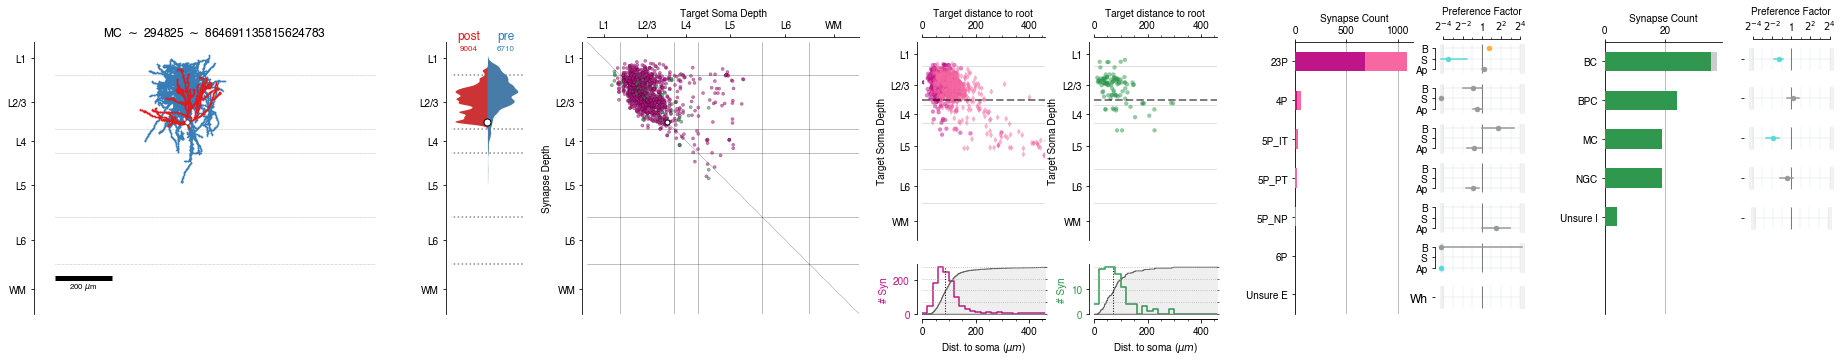

In [54]:
bins = create_binning(pre_syn_df, visConfig.min_dist_bin_max, visConfig.dist_bin_spacing)
fig = plt.figure(figsize=(33,5), dpi=72, facecolor='w')
gmain = fig.add_gridspec(1,6, wspace=0.05, width_ratios=(6, 1, 5, 4, 4, 4))

ax_morpho = fig.add_subplot(gmain[0,0])
morpho_plot(nrn,
           layerConfig.layer_bounds,
           visConfig.height_bounds,
           visConfig.width_bounds,
           linewidth=1,
           bar_length=200,
           axon_color=visConfig.axon_color,
           dendrite_color=visConfig.dendrite_color,
           ax=ax_morpho)
ax_morpho.set_title(f'{nrn_subtype} $\sim$ {nrn_soma_id} $\sim$ {oid}')

ax_syn_dens = fig.add_subplot(gmain[0,1])
synapse_depth_distribution_plot(
    oid,
    pd.concat([nrn.anno.pre_syn.df, nrn.anno.post_syn.df]),
    visConfig.height_bounds,
    layerConfig.layer_bounds,
    soma_depth=soma_depth,
    bw=visConfig.depth_bandwidth,
    post_color=visConfig.postsyn_color,
    pre_color=visConfig.presyn_color,
    ax=ax_syn_dens)
ax_syn_dens.set_ylabel(None)

ax_syns = fig.add_subplot(gmain[0,2])
synapse_location_plot(pre_syn_df,
                      visConfig.valence_palette,
                      layerConfig.layer_bounds,
                      layerConfig.height_bounds,
                      size=10,
                      alpha=0.6,
                      marker=visConfig.markers[0],
                      ax=ax_syns,
                      )

g1 = gmain[0,3]
g = g1.subgridspec(2,2, wspace=0.4, width_ratios=(1,1), height_ratios=(4,1))
ax_e_tall = fig.add_subplot(g[0,0])
compartment_target_distance_plot(pre_syn_df.query('classification_system == "aibs_coarse_excitatory"'),
                                  (visConfig.valence_palette, visConfig.apical_palette, visConfig.soma_palette),
                                  layerConfig.layer_bounds,
                                  visConfig.height_bounds,
                                  size=15,
                                  alpha=0.5,
                                  markers=visConfig.markers,
                                  ax=ax_e_tall,
                                  max_dist=np.max(bins[~np.isinf(bins)]),
                                  )

ax_e_hist = fig.add_subplot(g[1,0], sharex=ax_e_tall)
target_dist_from_soma(pre_syn_df.query('classification_system=="aibs_coarse_excitatory"'), color=visConfig.e_color, ax=ax_e_hist, bins=bins)

ax_i_tall = fig.add_subplot(g[0,1], sharey=ax_e_tall)
compartment_target_distance_plot(pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
                                  (visConfig.valence_palette, visConfig.apical_palette, visConfig.soma_palette),
                                  layerConfig.layer_bounds,
                                  visConfig.height_bounds,
                                  size=15,
                                  alpha=0.5,
                                  markers=visConfig.markers,
                                  ax=ax_i_tall,
                                  max_dist=np.max(bins[~np.isinf(bins)]),
                                  )

ax_i_hist = fig.add_subplot(g[1,1], sharex=ax_i_tall)
target_dist_from_soma(pre_syn_df.query('classification_system=="aibs_coarse_inhibitory"'), color=visConfig.i_color, ax=ax_i_hist, bins=bins)

g_excbar = gmain[0,4]
num_rows = max([len(catConfig.e_groups), len(catConfig.i_groups)])
target_summary_plot(pre_syn_df.query('classification_system == "aibs_coarse_excitatory"'),
                    res_df,
                    fig,
                    g_excbar,
                    catConfig.e_groups,
                    num_rows,
                    visConfig.e_component_palette,
                    width_ratio=3,
                    preference_width=0.75)

g_inhbar = gmain[0,5]
target_summary_plot(pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
                    res_df,
                    fig,
                    g_inhbar,
                    catConfig.i_groups,
                    num_rows,
                    visConfig.i_component_palette,
                    first_category='BC',
                    width_ratio=3,
                    preference_width=0.75)

# fig.set_tight_layout('tight')

In [ ]:
def output_count_bar(syn_df,
                     num_rows=None,
                     labels=None,
                     cell_type='cell_type',
                     hue='comp',
                     hue_order=None,
                     min_xmax=10,
                     palette=None,
                     first_category=None,
                     grid=True,
                     ax=None):
    if ax is None:
        ax = plt.gca()
    
    sns.histplot(y=cell_type, data=syn_df, hue=hue, multiple='stack', hue_order=hue_order,
                 palette=palette, ax=ax, linewidth=0, shrink=0.5, legend=False, zorder=10, alpha=1)

    if grid:
        ax.grid(axis='x', zorder=-10)

    if num_rows is not None:
        if first_category is not None:
            offset = np.flatnonzero(
                syn_df[cell_type].cat.categories == first_category)-1
            ax.set_ylim(offset+num_rows+0.5, offset+.5)
        else:
            ax.set_ylim(num_rows-0.5, -0.5)

    sns.despine(ax=ax, top=False, bottom=True)

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Synapse Count')
    if labels is not None:
        ax.set_yticklabels(labels)

    if ax.get_xlim()[1] < min_xmax:
        ax.set_xlim(0, min_xmax)

    ax.set_ylabel(None)
    return ax

In [ ]:
pre_syn_df.groupby(['is_apical', 'cell_type']).count()

In [81]:
from pykdtree import kdtree

In [84]:
syn_pts = np.vstack(syn_profile_bin_comp_df['ctr_pt_position'].values) * voxel_resolution

In [85]:
syn_pts.shape

(4120888, 3)

In [93]:
from scipy.spatial.kdtree import cKDTree

In [99]:
kd_tree = cKDTree(syn_pts)

In [ ]:
kd_tree = cKDTree

In [98]:
kd_tree = kdtree.KDTree(syn_pts)

In [106]:
out = kd_tree.query_ball_point(nrn.anno.pre_syn.points, 5000)

In [108]:
potential_targets = syn_profile_bin_comp_df.iloc[np.concatenate(out)]

cell_type
23P         361124
4P           63918
5P_IT        21709
5P_NP          751
5P_PT        17897
6P            3478
BC           44569
BPC          13690
MC           27614
NGC           6471
Unsure E       344
Unsure I      4295
Name: potential_syn, dtype: int64

In [112]:
pre_syn_df = process_presyn_df(nrn, syn_profile_bin_comp_df, soma_target_df, catConfig)

In [121]:
df = pd.DataFrame([pre_syn_df.groupby('cell_type').count()['valid'].rename('actual_syn'), 
              potential_targets.groupby('cell_type').count()['id'].rename('potential_syn')]).transpose()

In [123]:
df['filling'] = df['actual_syn'] / df['potential_syn']

In [124]:
df

,actual_syn,potential_syn,filling
cell_type,,,
23P,643,361124,0.001781
4P,244,63918,0.003817
5P_IT,56,21709,0.002580
5P_NP,4,751,0.005326
5P_PT,13,17897,0.000726
6P,4,3478,0.001150
BC,60,44569,0.001346
BPC,15,13690,0.001096
MC,21,27614,0.000760


In [ ]:
def process_presyn_df(nrn,
                      syn_profile_bin_comp_df,
                      soma_target_df,
                      catConfig):
    
    pre_syn_df = nrn.anno.pre_syn.df
    
    # Add cell type and component information
    pre_syn_df = pre_syn_df.merge(syn_profile_bin_comp_df[['id', 'dist_to_root', 'syn_depth', 'is_apical', 'is_soma', 'is_dendrite', 'cell_type', 'cell_type_comp', 'layer', 'classification_system']],
                                  how='inner',
                                  on='id')
    pre_syn_df['cell_type'] = pd.Categorical(
        pre_syn_df['cell_type'], categories=catConfig.order, ordered=True)
    # Add target soma depth
    pre_syn_df = pre_syn_df.merge(soma_target_df, how='left', on='post_pt_root_id')
    pre_syn_df['comp'] = pre_syn_df.apply(define_comp, axis=1)
    pre_syn_df['comp'] = pd.Categorical(pre_syn_df['comp'], categories=['soma', 'basal', 'apical', 'other'][::-1], ordered=True)

    try:
        pre_syn_df = pre_syn_df.rename(columns={'syn_depth': 'syn_depth_um'})
    except:
        pass
    return pre_syn_df

In [ ]:
def define_comp(row):
    if row['is_soma']:
        return 'soma'
    elif row['is_apical']:
        return 'apical'
    elif row['is_dendrite']:
        return 'basal'
    else:
        return 'other'

In [ ]:
syn_profile_count_comp_long

In [ ]:
pre_syn_df.head()

In [ ]:
pre_syn_df = pre_syn_df.rename(columns={'syn_depth': 'syn_depth_um'})

syn_df_bin_count_long = full_synapse_data(
        pre_syn_df,
        'cell_type_comp',
        layer_bins,
        syn_profile_count_comp_long,
        order=catConfig.order_comp)

res_df = stratified_tables(
    syn_df_bin_count_long, 'cell_type_comp', order=catConfig.order_comp)

In [ ]:
res_df

In [ ]:
pre_syn_df['cell_type'] = pd.Categorical(
    pre_syn_df['cell_type'], categories=catConfig.order, ordered=True)

syn_df_ct_val = syn_df_ct.merge(
    cell_type_df[['pt_root_id', 'valence']], left_on='post_pt_root_id', right_on='pt_root_id', how='inner').drop(columns='pt_root_id')

res_df = stratified_tables(
    syn_df_bin_count_long, 'cell_type_comp', order=catConfig.order_comp)

In [ ]:
syn_profile_comp_count

In [ ]:
pre_syn_df.head()

In [ ]:
output_preference_index(res_df, i_groups, axes=axs_i_spec, extra_mult=2,
                        cell_type_column='cell_type_comp', palette=visConfig.spec_palette)


In [ ]:
fig, axes = plt.subplots(figsize=(5,5), ncols=2)
sns.histplot(y='cell_type',
             hue='comp',
             multiple='stack',
             data=pre_syn_df.query('classification_system == "aibs_coarse_excitatory"'),
             hue_order=['soma', 'apical', 'basal', 'other'][::-1],
             palette='Purples',
             ax=axes[0])

sns.histplot(y='cell_type',
             hue='comp',
             multiple='stack',
             data=pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
             hue_order=['soma', 'apical', 'basal', 'other'][::-1],
             palette='Greens',
             ax=axes[1])

In [ ]:
fig, ax = plt.subplots(figsize=(2,5), facecolor='w', dpi=150)
output_count_bar(pre_syn_df.query('classification_system == "aibs_coarse_inhibitory"'),
                 first_category='BC',
                 num_rows=7,
                 labels=None,
                 cell_type='cell_type',
                 hue='classification_system',
                 min_xmax=10,
                 palette=palette,
                 ax=ax)

In [ ]:
oid = 864691135571206437

In [ ]:
column_df = cell_type_df
cell_type_column = 'cell_type_comp'
background_comp_long = syn_profile_count_comp_long

syn_df = get_syn_df(oid, synapse_table, client)
pre_syn_df = syn_df.query('pre_pt_root_id == @oid')

nrn_subtype, nrn_soma_id, soma_position = neuron_info(oid, soma_df)

if soma_position is not None:
    soma_depth = soma_position[1]/1000
else:
    soma_depth = None

voxel_resolution = [4, 4, 40]
pre_syn_df['syn_depth'] = syn_depth(pre_syn_df, voxel_resolution)
syn_df_ct = synapse_compartment_profile(pre_syn_df, column_df)
syn_df_ct[cell_type_column] = add_layer_column(
    syn_df_ct, cell_type_column, column_df, 'soma_depth_um', layerConfig.layer_bounds, layerConfig.layers, catConfig.i_groups)

syn_df_bin_count_long = full_synapse_data(
    syn_df_ct, cell_type_column, layer_bins, background_comp_long, order=catConfig.order_comp)

syn_df_ct['cell_type'] = pd.Categorical(
    syn_df_ct['cell_type'], categories=catConfig.order, ordered=True)
syn_df_ct_val = syn_df_ct.merge(
    column_df[['pt_root_id', 'valence']], left_on='post_pt_root_id', right_on='pt_root_id', how='inner').drop(columns='pt_root_id')

res_df = stratified_tables(
    syn_df_bin_count_long, 'cell_type_comp', order=catConfig.order_comp)

e_groups = catConfig.e_groups
i_groups = catConfig.i_groups

num_rows = max(len(e_groups), len(i_groups))

fig = plt.figure(figsize=(30, 5), dpi=72, facecolor='w')

gs_overall = fig.add_gridspec(
    1, 3, wspace=0.025, width_ratios=(1.5, 1, 0.2))
gs_space = gs_overall[0].subgridspec(
    nrows=1, ncols=3, wspace=0.1, width_ratios=(5, 1, 5))
gs_budget = gs_overall[:, 1].subgridspec(
    nrows=1, ncols=3, wspace=0.4, width_ratios=(4, 4, 0.5))
gs_input = gs_overall[:, 2].subgridspec(ncols=2, nrows=1,
                                        wspace=0.2,
                                        width_ratios=[1.5, 4])


ax_anat = fig.add_subplot(gs_space[:, 0])
pcg_anatomy_projection(oid, client.info.segmentation_source(), ax_anat, layers=layerConfig.layer_bounds, width_bounds=visConfig.width_bounds,
                       depth_bounds=visConfig.height_bounds, soma_position=soma_position, color='k', offset=0, alpha=0.3)
ax_anat.set_ylabel(None)
ax_anat.set_title(build_title(nrn_subtype, nrn_soma_id, oid))

# Synapse distribution
ax_syn = fig.add_subplot(gs_space[:, 1])
synapse_depth_distribution_plot(
    oid, syn_df, visConfig.height_bounds, layerConfig.layer_bounds, soma_depth=soma_depth, ax=ax_syn)
ax_syn.set_ylabel(None)


# Synapse points
ax_pts = fig.add_subplot(gs_space[:, 2])

synapse_location_plot(oid, syn_df, column_df, 100, 1000, layerConfig.layer_bounds,
                      visConfig.height_bounds, ax=ax_pts, s=15, fill_background=False,
                      hue_column='valence', alpha=0.5, palette=visConfig.val_color, soma_df=column_df,
                      background_colors=((0.739, 0.742, 0.134), (0.980, 0.692, 0.894)))


gs_output_budget = gs_budget[:, 2].subgridspec(
    nrows=2, ncols=1, hspace=0.2, height_ratios=(4, 1))
ax_budget = fig.add_subplot(gs_output_budget[0])
pre_syn_soma_df = output_categories(
    pre_syn_df, column_df, soma_count_df)

ax = output_category_budget(
    pre_syn_soma_df, categories=catConfig.syn_cat, palette=visConfig.cat_pal, ax=ax_budget)
ax.legend(['Col', 'NonCol', 'Multi', 'Orph'][::-1],
          bbox_to_anchor=(1.3, 0), fontsize='small')

#
gs_exc = gs_budget[:, 0].subgridspec(
    nrows=num_rows, ncols=2, wspace=0.35)

ax_e_bar = fig.add_subplot(gs_exc[:, 0])
output_count_bar(syn_df_ct_val.dropna().query('valence == "Exc"'), num_rows=num_rows, labels=None,
                 cell_type='cell_type', hue='valence', min_xmax=10, palette=visConfig.val_color, ax=ax_e_bar)

axes_e_spec = []
for col in range(num_rows):
    axes_e_spec.append(fig.add_subplot(gs_exc[col, 1]))

output_preference_index(res_df, e_groups, axes=axes_e_spec, extra_mult=2,
                        cell_type_column='cell_type_comp', palette=visConfig.spec_palette)

# Inhibitory panel pair
gs_inh = gs_budget[:, 1].subgridspec(
    nrows=num_rows, ncols=2, wspace=0.35)

ax_i_bar = fig.add_subplot(gs_inh[:, 0])

output_count_bar(syn_df_ct_val.dropna(subset=['cell_type']).query('valence == "Inh"'), num_rows=num_rows, labels=None,
                 cell_type='cell_type', hue='valence', min_xmax=10, palette=visConfig.val_color, first_category='BC', ax=ax_i_bar)

axes_i_spec = []
for col in range(num_rows):
    axes_i_spec.append(fig.add_subplot(gs_inh[col, 1]))
    
i_groups = [{'cts': ['BC'],
  'labels': ['']},
 {'cts': ['BPC'],
  'labels': ['']},
 {'cts': ['MC'],
  'labels': ['']},
 {'cts': ['NGC'],
  'labels': ['']},
 {'cts': ['Unsure'],
  'labels': ['']}]
output_preference_index(res_df, i_groups, axes=axs_i_spec, extra_mult=2,
                        cell_type_column='cell_type_comp', palette=visConfig.spec_palette)


In [ ]:
pcg_anatomy_projection(oid, client.info.segmentation_source(), ax_anat, layers=layerConfig.layer_bounds, width_bounds=visConfig.width_bounds,
                       depth_bounds=visConfig.height_bounds, soma_position=soma_position, color='k', offset=0, alpha=0.3)

In [ ]:
visConfig.

In [ ]:
def anatomy_plot(nrn, ax, layers, horizontal_bounds, depth_bounds, soma_position=None, alpha=0.3, dendrite_color=(), axon_color=())
    

In [ ]:
if use_skeleton:
    nrn = meshwork.load_meshwork(f'{project_paths.skeletons}/skeleton_files/{oid}.h5')
    soma_position = nrn.skeleton.vertices[nrn.skeleton.root]

    cell_soma_df = client.materialize.query_table(soma_table, filter_equal_dict={'pt_root_id': nrn.seg_id})
    if len(cell_soma_df)>0:
        nrn_soma_id = cell_soma_df['id'].iloc[0]
    else:
        nrn_soma_id = None

    nrn_row = cell_type_df.query('pt_root_id == @oid')
    if len(nrn_row) == 1:
        nrn_subtype = nrn_row['cell_type'].iloc[0]
    else:
        nrn_subtype = None

In [ ]:
res_df

In [ ]:
res_df

In [ ]:
syn_df_ct_val.dropna().query('valence == "Exc"')

In [ ]:
sns.histplot(y='cell_type', data=syn_df_ct_val.dropna().query('valence == "Exc"'), hue='valence')

In [ ]:
from cloudfiles import CloudFiles

In [ ]:
cf = CloudFiles?

In [ ]:
                nrn.save_meshwork(temp_fname, overwrite=True)
                with open(temp_fname, "rb") as fp:
                    data = fp.read()
                cf.put(fname, data, content_type="application/x-hdf")

In [ ]:
import tempfile

In [ ]:
def save_to_cloudfile(save_function, filename_arg, cloudfile, content_type, save_kwargs={}):
    